<a href="https://colab.research.google.com/github/change0z/vault-055/blob/main/PolyDesign_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux
!pip install transformers scipy ftfy accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers.utils import load_image

from google.colab import files
from io import BytesIO
from PIL import Image

uploaded = files.upload()
image = Image.open(BytesIO(uploaded['output.png']))

Saving output.png to output (2).png


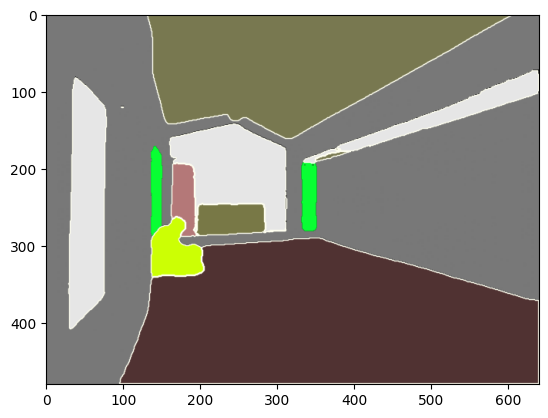

In [3]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.show()

In [4]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image
import numpy as np
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

In [5]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-seg", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "SG161222/Realistic_Vision_V2.0", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [6]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [7]:
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/50 [00:00<?, ?it/s]

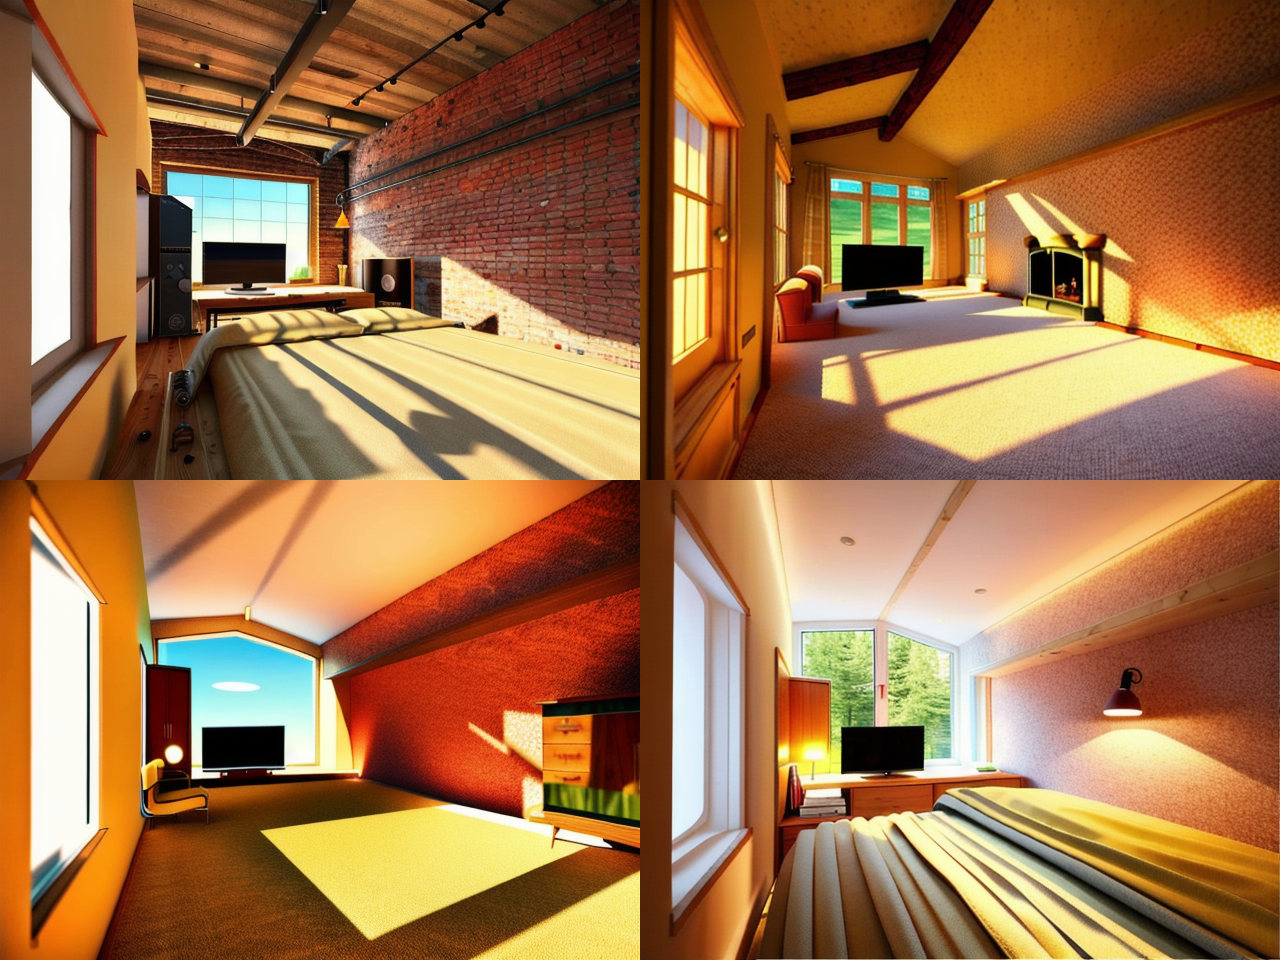

In [14]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = " style room with a desk, television, a mini bed and a fireplace in the corner of the room, cozy lighting, shadow, natural lighting, masterpiece, best quality, without modifying the existing window"
#prompt = "living sapce with a desk, television and a sofa"
prompt = [t + prompt for t in ["Industrial", "Country House", "Midcentury", "Scandinavian"]]
generator = [torch.Generator(device="cpu").manual_seed(3) for i in range(len(prompt))]
#generator = [torch.Generator(device="cpu").manual_seed(175889312071665) for i in prompt.split(", ")]

output = pipe(
    prompt,
    image,
    negative_prompt=["monochrome, lowres, worst quality, low quality"] * len(prompt),
    generator=generator,
    guidance_scale = 20,
    num_inference_steps=50,
)

image_grid(output.images, 2, 2)

#print(prompt)

In [ ]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-seg", torch_dtype=torch.float16)


In [ ]:
model_id = "SG161222/Realistic_Vision_V2.0"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

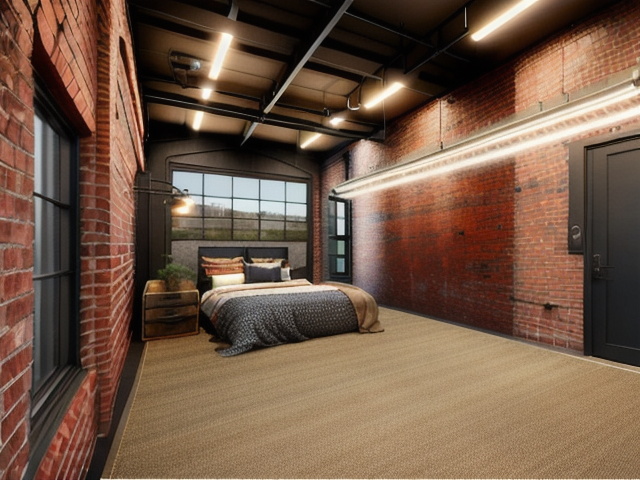

In [19]:
generator = torch.manual_seed(3)
prompt = "a bedroom with industrial style furniture, a large metal bed, a dresser, a chair, a lamp, an industrial style nightstand, (realistic lighting and textures), by artgerm lau"
#prompt = "bedroom with white walls, large bed, dresser, nightstand with lamp and phone, a TV, a fireplace, window looking out at valley, (realistic bedroom scene, high resolution photo), trending on pinterest"
#prompt = "style room with a desk, bed, television, fireplace , cozy lighting, shadow, natural lighting, masterpiece, best quality, without modifying the existing window"
output = pipe(
    prompt,
    image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality, do not remove bed",
    generator=generator,
    guidance_scale = 20,
    num_inference_steps=50,
)
output.images[0]